In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.simplefilter("ignore")

### I could build this into script-only, output-a-report, log-to-favourite-expt-tracking-solution, but...
<br>I still just want to iterate quickly and play around with different options, so I'll do it in a notebook

In [2]:
from trainer import CensusTrainer
import copy
import json

In [3]:
with open("census_data_col_names.json", "r") as f:
    column_names = json.load(f)
df_test = pd.read_csv("census_income_test.csv", names=column_names)
df_train = pd.read_csv("census_income_learn.csv", names=column_names)

### first pass, expressing the "feature engineering decisions" from EDA notebook into a config:

In [4]:
scale = True
lr_process_config = {}
for feat in ["age", "wage_per_hour", "capital_gains", "capital_losses", "dividends_from_stocks", "num_persons_worked_for_employer", "weeks_worked_in_year"]:
    lr_process_config[feat] = {"processor": "numeric",
                               "kwargs": {"scale": scale}}
    
lr_process_config |= {
    "class_of_worker": {"processor": "binary_flag",
                        "args": [["Not in universe"]],
                        "kwargs": {"scale": scale,
                                   "new_feature_name": "worker_not_in_class_universe"}},
    
    "detailed_industry_recode": {"processor": "binary_flag",
                                 "args": [["0"]],
                                 "kwargs": {"scale": scale,
                                            "new_feature_name": "works_in_agriculture_industry"}},
    
    "education": {"processor": "binary_flag",
                  "args": [["Bachelors degree(BA AB BS)", "Doctorate degree(PhD EdD)", "Masters degree(MA MS MEng MEd MSW MBA)", "Prof school degree (MD DDS DVM LLB JD)"]],
                  "kwargs": {"scale": scale,
                             "new_feature_name": "has_higher_education"}},
    
    "enroll_in_edu_inst_last_wk": {"processor": "binary_flag",
                                   "args": [["College or university", "High school"]],
                                   "kwargs": {"scale": scale,
                                              "new_feature_name": "still_in_education"}},
    
    "marital_stat": {"processor": "ordinal",
                     "args": [{2: ["Married-civilian spouse present"],
                               0: ["Never married"]}],
                     "kwargs": {"unspecified_categoricals_value": 1,
                                "scale": scale,
                                "new_feature_name": "never_married__other__married_(Lo-Hi)"}},
    
    "major_industry_code": {"processor": "binary_flag",
                            "args": [["Not in universe or children"]],
                            "kwargs": {"scale": scale,
                                       "new_feature_name": "child_or_industry_unknown"}},
    
    "sex": {"processor": "binary_flag",
            "args": [["Male"]],
            "kwargs": {"scale": scale,
                       "new_feature_name": "individual_is_male"}},
    
    "full_or_part_time_employment_stat": {"processor": "ordinal",
                                          "args": [{2: ["Full-time schedules"],
                                                    0: ["Children or Armed Forces", "Not in labor force"]}],
                                          "kwargs": {"unspecified_categoricals_value": 1,
                                                     "scale": scale,
                                                     "new_feature_name": "nolabour_forces_child__other__fulltime_(Lo-Hi)"}},
    
    "tax_filer_stat": {"processor": "ordinal",
                       "args": [{2: ["Joint both under 65"],
                                 0: ["Nonfiler"]}],
                       "kwargs": {"unspecified_categoricals_value": 1,
                                  "scale": scale,
                                  "new_feature_name": "non_tax_filer__other__joint_worker_filers_(Lo-Hi)"}},
    
    "detailed_household_summary_in_household": {"processor": "ordinal",
                                                "args": [{2: ["Householder"],
                                                          0: ["Child 18 or older", "Child under 18 never married", "Child under 18 ever married"]}],
                                                "kwargs": {"unspecified_categoricals_value": 1,
                                                           "scale": scale,
                                                           "new_feature_name": "child_w_parents__other__main_householder_(Lo-Hi)"}},
    
    "country_of_birth_mother": {"processor": "binary_flag",
                                "args": [["Mexico", "Puerto-Rico"]],
                                "kwargs": {"scale": scale,
                                           "new_feature_name": "mother_born_in_mexico_or_puerto_rico"}},
    # That's probably enough for now
}

with open("logistic_regressor_initial_preprocessing_config.json", "w") as f:
    json.dump(lr_process_config, f)

### Experiment time!

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     37523
           1       0.19      0.89      0.32      2422

    accuracy                           0.77     39945
   macro avg       0.59      0.83      0.59     39945
weighted avg       0.94      0.77      0.83     39945

AUC score: 0.904


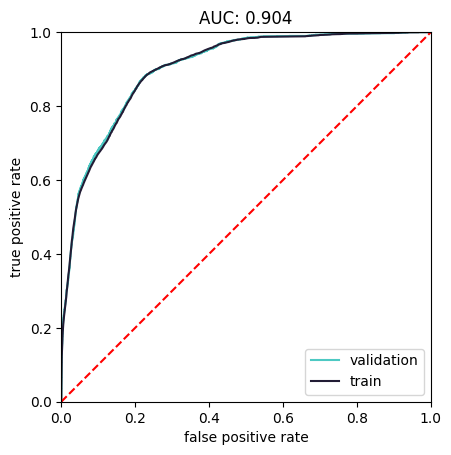

In [5]:
trainer = CensusTrainer(df_train,
                       {"preprocessing": lr_process_config,
                        "train": {"classifier": "LogisticRegression",
                                  "penalty": "l2",
                                  "fit_intercept": False,
                                  "solver": "lbfgs",
                                  "max_iter": 200
                                 },
                        "experiment_name": "LR_v0.0.0"})

trainer.preprocess_data()
trainer.train_classifier()
trainer.evaluate_classifier()

### Crude overfitting-alarm not ringing just yet...

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     37523
           1       0.20      0.89      0.32      2422

    accuracy                           0.77     39945
   macro avg       0.59      0.83      0.59     39945
weighted avg       0.94      0.77      0.83     39945

AUC score: 0.904


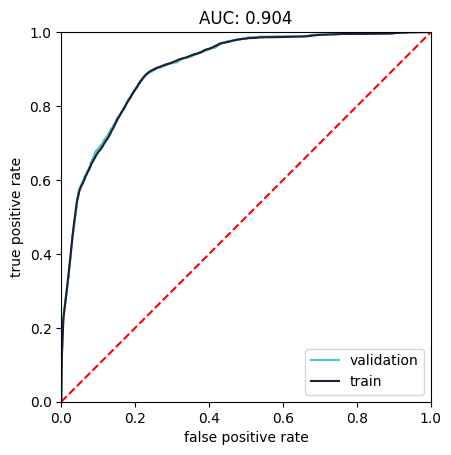

In [6]:
trainer = CensusTrainer(df_train,
                       {"preprocessing": lr_process_config,
                        "train": {"classifier": "LogisticRegression",
                                  "penalty": None,
                                  "fit_intercept": False,
                                  "solver": "lbfgs",
                                  "max_iter": 200,
                                  "C": 0.1
                                 },
                        "experiment_name": "LR_v0.0.1"})

trainer.preprocess_data()
trainer.train_classifier()
trainer.evaluate_classifier()

### Hmmm... fiddling with hyperparams doesn't do much here... possibly breing limited by the feature set. Let's just check test performance and move on

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     93576
           1       0.20      0.90      0.33      6186

    accuracy                           0.77     99762
   macro avg       0.60      0.83      0.59     99762
weighted avg       0.94      0.77      0.83     99762

Test AUC score: 0.905


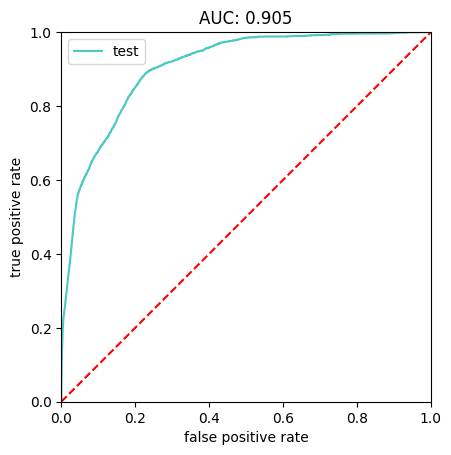

In [7]:
trainer.evaluate_on_unseen_dataset(df_test)

# Tiny bit better, but essentially the same

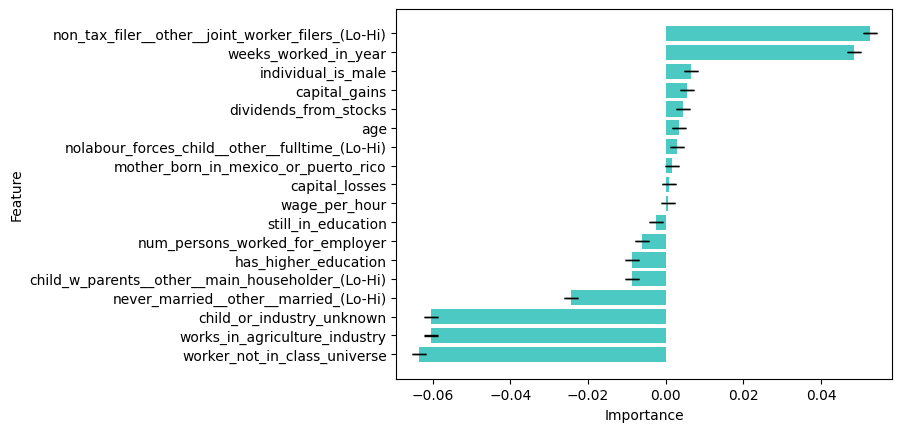

In [8]:
trainer.get_permutation_feature_importances()

Worth noting: https://scikit-learn.org/stable/modules/permutation_importance.html#misleading-values-on-strongly-correlated-features

(this is why I don't like the permutation importance function)